In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import random
import matplotlib
import matplotlib.pyplot as plt

from scipy import sparse
import xgboost as xgb
from surprise import Reader, Dataset, accuracy
from surprise.prediction_algorithms import NormalPredictor, KNNWithMeans, KNNBasic, SVD, SVDpp
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV

## Load and Clean Dataset

In [2]:
df = pd.read_csv('beer_reviews.csv', usecols=["beer_beerid","review_profilename", "review_overall", "review_time"])
df = df.rename(columns={"beer_beerid": "item", "review_profilename": "user", "review_overall": "rating"})
print(len(df))
df.head()

1586614


,review_time,rating,user,item
0,1234817823,1.5,stcules,47986
1,1235915097,3.0,stcules,48213
2,1235916604,3.0,stcules,48215
3,1234725145,3.0,stcules,47969
4,1293735206,4.0,johnmichaelsen,64883


In [3]:
unique_user = df["user"].unique()
user2idx = {old: new for new, old in enumerate(unique_user)}
df["user"] = df["user"].apply(lambda x: user2idx[x])
unique_item = df["item"].unique()
item2idx = {old: new for new, old in enumerate(unique_item)}
df["item"] = df["item"].apply(lambda x: item2idx[x])
df.head()

,review_time,rating,user,item
0,1234817823,1.5,0,0
1,1235915097,3.0,0,1
2,1235916604,3.0,0,2
3,1234725145,3.0,0,3
4,1293735206,4.0,1,4


In [4]:
df = df.drop_duplicates().dropna()
df["rating"] = pd.to_numeric(df["rating"])
print(len(df))
df.head()

1586612


,review_time,rating,user,item
0,1234817823,1.5,0,0
1,1235915097,3.0,0,1
2,1235916604,3.0,0,2
3,1234725145,3.0,0,3
4,1293735206,4.0,1,4


/tmp/ipykernel_184/1635630146.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


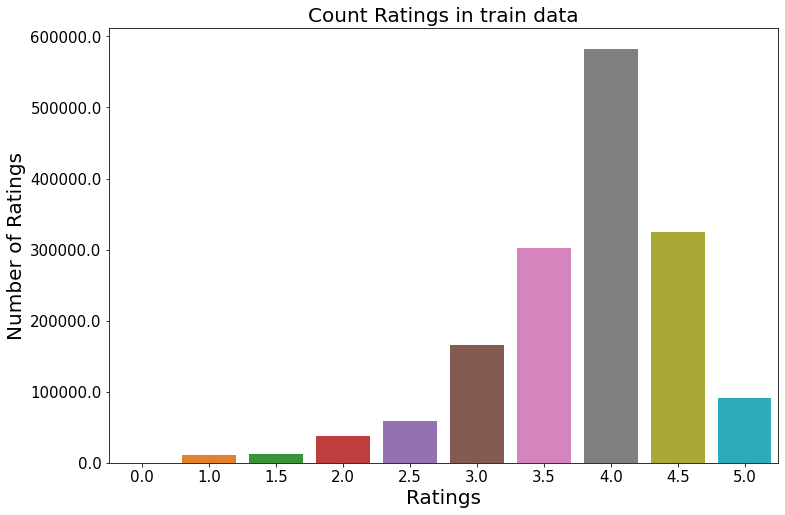

In [5]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=df)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

In [6]:
ratings_per_user = df.groupby("user")["rating"].count().sort_values(ascending=False)
ratings_per_user.describe()

count    33388.000000
mean        47.520427
std        182.604079
min          1.000000
25%          1.000000
50%          3.000000
75%         16.000000
max       5817.000000
Name: rating, dtype: float64

In [7]:
ratings_per_item = df.groupby("item")["rating"].count().sort_values(ascending=False)
ratings_per_item.describe()

count    66055.000000
mean        24.019559
std        110.864137
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max       3290.000000
Name: rating, dtype: float64

In [8]:
df = df.groupby("user").filter(lambda g: g["rating"].count() > 30)
df = df.groupby("item").filter(lambda g: g["rating"].count() > 15)
print(len(df))
df.head()

1277867


,review_time,rating,user,item
10,1010963392,3.0,7,6
18,1010861086,2.5,15,6
19,1325478004,4.5,16,9
20,1325360812,4.0,17,9
21,1322506304,4.0,18,9


In [9]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(df[["user", "item", "rating"]], reader)
train_data, test_data = train_test_split(data, test_size=.2)

In [15]:
naive_baseline_tunned = NormalPredictor()
naive_baseline_tunned.fit(train_data)
naive_baseline_pred = naive_baseline_tunned.test(test_data)

accuracy.rmse(naive_baseline_pred)
accuracy.mae(naive_baseline_pred)

RMSE: 0.9684
MAE:  0.7618


0.761754857575507

In [11]:
knn_mean_item_tunned = KNNWithMeans(sim_options={'name': 'cosine',
                                         'user_based': False,
                                         'min_support': True,
                                         'min_k': 2})
knn_mean_item_tunned.fit(train_data)
knn_mean_item_pred = knn_mean_item_tunned.test(test_data)

accuracy.rmse(knn_mean_item_pred)
accuracy.mae(knn_mean_item_pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5843
MAE:  0.4387


0.43873544572291195

In [12]:
knn_mean_user_tunned = KNNWithMeans(sim_options={'name': 'cosine',
                                         'user_based': True,
                                         'min_support': True,
                                         'min_k': 2})
knn_mean_user_tunned.fit(train_data)
knn_mean_user_pred = knn_mean_user_tunned.test(test_data)

accuracy.rmse(knn_mean_user_pred)
accuracy.mae(knn_mean_user_pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.5953
MAE:  0.4503


0.4503473385063016

In [12]:
svd = SVD()
svd.fit(train_data)
svd_pred = svd.test(test_data)

accuracy.rmse(svd_pred)
accuracy.mae(svd_pred)

RMSE: 0.5803
MAE:  0.4350


0.43496631401595387

In [13]:
svdpp = SVDpp()
svdpp.fit(train_data)
svdpp_pred = svdpp.test(test_data)

accuracy.rmse(svdpp_pred)
accuracy.mae(svdpp_pred)

RMSE: 0.5754
MAE:  0.4308


0.4307997836396063